# Compressed sensing solve with ISTA, FISTA and AFBN(FISTA variate)

Optimization problem:

\begin{equation}
\textrm{min} \qquad ||Ax-b||_2^2 + \lambda ||x||_1
\end{equation}


In [14]:
%matplotlib inline
import scipy.fftpack as spfft
import matplotlib.pyplot as plt
import numpy as np

In [15]:
def soft_thresh(x, alpha):
    return np.sign(x) * np.maximum(np.abs(x) - alpha, 0.)

def ista(A, b, lmbda = 1., niter=10):
    costs=[]
    x = np.zeros(A.shape[1])
    L = np.linalg.norm(np.dot(A.T,A),2)
    # Lipschitz constant
    t = 1 / L # apropriated stepsize
    alpha = lmbda * t
    for _ in range(niter):
        gradient_x = 2 * t * A.T.dot(A.dot(x)-b)
        x = soft_thresh(x - gradient_x,alpha)
        costs.append(np.linalg.norm(A.dot(x)-b,2) ** 2 + lmbda * np.linalg.norm(x,1))
    return x,costs

def fista(A, b, lmbda = 1., niter=10):
    x = np.zeros(A.shape[1])
    t = 1
    z = x.copy()
    L = np.linalg.norm(np.dot(A.T,A),2)# Lipschitz constant
    stepsize = 1 / L
    alpha = lmbda * stepsize
    costs = []
    for _ in range(niter):
        xold = x.copy()
        gradient_z = stepsize * 2 * A.T.dot(A.dot(z) - b)
        z = z - gradient_z
        x = soft_thresh(z, alpha)
        t0 = t
        t = (1. + np.sqrt(1. + 4. * t ** 2)) / 2.
        z = x + ((t0 - 1.) / t) * (x - xold)
        costs.append(np.linalg.norm(A.dot(x) - b,2) ** 2 + lmbda * np.linalg.norm(x, 1))
    return x,costs

def afbn(A, b,lmbda = 1.,beta=4.,niter=10):
    x = np.zeros(A.shape[1])
    z = x.copy()
    L = np.linalg.norm(np.dot(A.T,A),2)
    stepsize = 1 / L
    alpha = lmbda * stepsize
    costs = []
    for k in range(niter):
        xold = x.copy()
        gradient_z = stepsize * 2 * A.T.dot(A.dot(z)-b)
        z = z - gradient_z
        x = soft_thresh(z,alpha)
        z = x + (k - 1.) / (k+beta-1) * (x - xold)
        costs.append(np.linalg.norm(A.dot(x) - b,2) ** 2 + lmbda * np.linalg.norm(x, 1))
    return x,costs

In [16]:
n = 5000
l = 1 / 8
t = np.linspace(0,l,n)
dt = t[1]-t[0]

# defining the signal
x = np.sin(2 * np.pi * 97 * t ) + np.cos(2 * np.pi * 277 * t)
xf = spfft.dct(x) #obtain the frequency representaion from the signal via discrete cossine transformation

(0.0, 100.0)

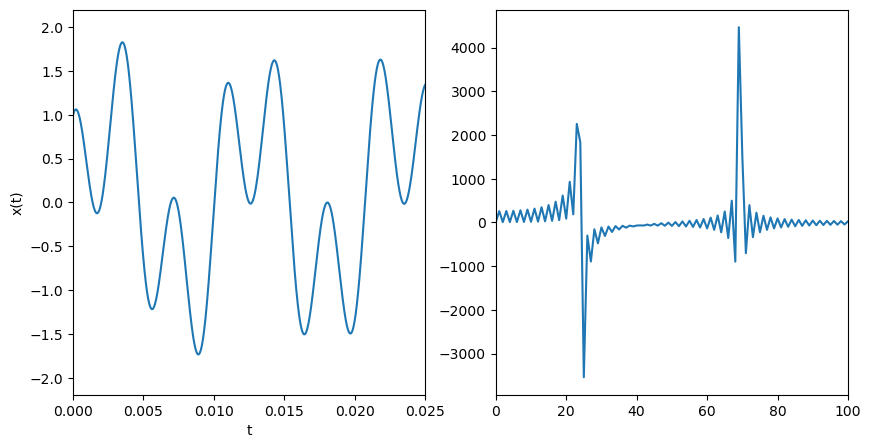

In [17]:
fig, axs = plt.subplots(1,2,figsize=(10,5))
axs[0].plot(t,x)
axs[0].set_xlabel('t')
axs[0].set_ylabel('x(t)')
axs[0].set_xlim(0,.025)
axs[1].plot(np.arange(n),xf)
axs[1].set_xlim(0,100)

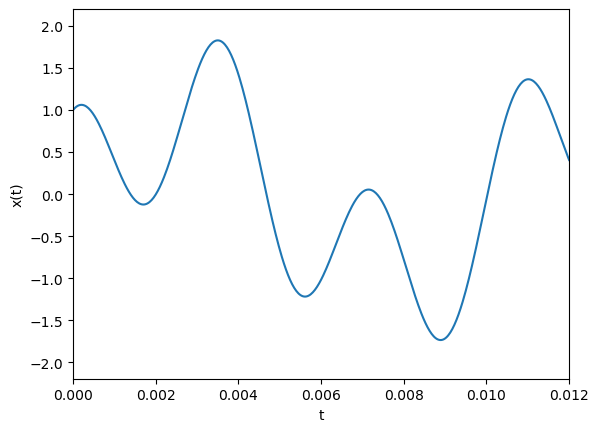

In [18]:
plt.plot(t,x)
plt.xlim(0,0.012)
plt.xlabel('t')
plt.ylabel('x(t)')
plt.show()

In [19]:
# sampling
perc = 10
k = round( perc/100 * n)
ri = np.random.choice(n,k) #random indices
b = x[ri]

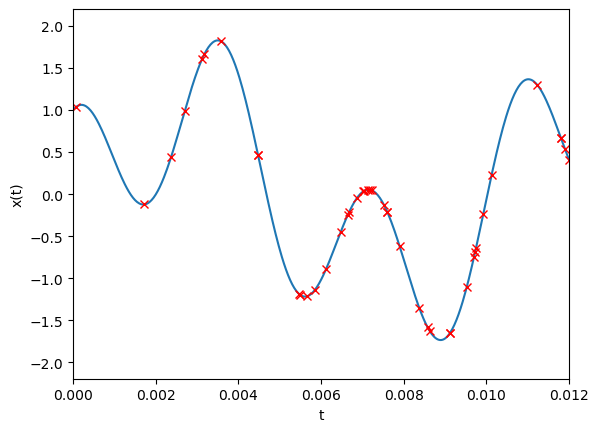

In [20]:
plt.plot(t,x,)
plt.plot(t[ri],b,'x',color='red')
plt.xlim(0,0.012)
plt.xlabel('t')
plt.ylabel('x(t)')
plt.show()

In [21]:
A = spfft.idct(np.identity(n), norm='ortho', axis=0) #Defining the operator A
A = A[ri] # defining PHI A, the operetator sampled
niter = 400
lmbda = 0.2

In [22]:
sista,costista = ista(A=A,b=b,lmbda=lmbda,niter=niter)
xista = spfft.idct(sista,norm='ortho',axis=0)

In [23]:

sfista,costsfista = fista(A=A,b=b,lmbda=lmbda,niter=niter)
xfista = spfft.idct(sfista,norm='ortho',axis=0)


In [24]:
betas=[3.,10.,100.,200.]
varafbn=[]
for beta in betas:
    safbn, costsafbn = afbn(A=A, b=b,lmbda = lmbda,beta=beta, niter = niter)
    xafbn = spfft.idct(safbn, norm='ortho', axis=0)
    varafbn.append([safbn,costsafbn,xafbn])

Text(0.5, 0.98, ' niter = 400')

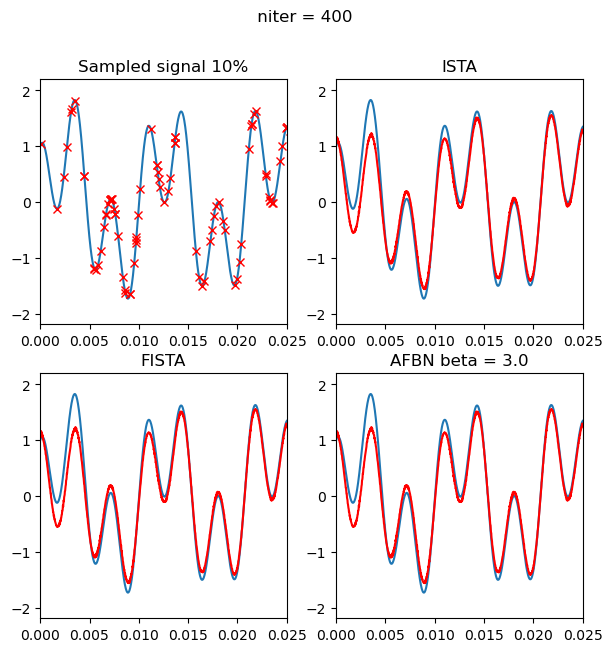

In [25]:
fig, axs = plt.subplots(2, 2, figsize=(7, 7))
axs[0, 0].plot(t, x)
axs[0, 0].plot(t[ri],b,'x',color='red')
axs[0,0].set_xlim(0,.025)
axs[0, 0].set_title(f'Sampled signal {perc}%')
axs[0, 1].plot(t, x, t, xista, 'r')
axs[0,1].set_xlim(0,.025)
axs[0, 1].set_title('ISTA')
axs[1, 0].plot(t, x, t, xfista, 'r')
axs[1,0].set_xlim(0,.025)
axs[1, 0].set_title('FISTA')
axs[1, 1].plot(t, x, t, varafbn[0][2], 'r')
axs[1,1].set_xlim(0,.025)
axs[1, 1].set_title(f'AFBN beta = {betas[0]}')
fig.suptitle(f' niter = {niter}')

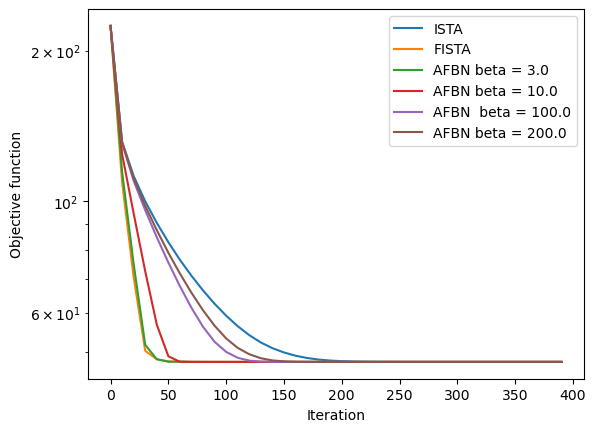

In [26]:
iter=range(0,niter,10)
fig,axs=plt.subplots()
axs.semilogy(iter,costista[::10])
axs.semilogy(iter,costsfista[::10])
axs.semilogy(iter,varafbn[0][1][::10])
axs.semilogy(iter,varafbn[1][1][::10])
axs.semilogy(iter,varafbn[2][1][::10])
axs.semilogy(iter,varafbn[3][1][::10])

axs.legend(['ISTA','FISTA',
            f'AFBN beta = {betas[0]}',
            f'AFBN beta = {betas[1]}',
            f'AFBN  beta = {betas[2]}',
            f'AFBN beta = {betas[3]}'])
axs.set_xlabel('Iteration')
axs.set_ylabel('Objective function')
plt.show()

## References



Beck, Amir, and Marc Teboulle. "A fast iterative shrinkage-thresholding algorithm for linear inverse problems." SIAM journal   on imaging sciences 2.1 (2009): 183-202.

https://humaticlabs.com/blog/compressed-sensing-python/

ttps://gist.github.com/agramfort/ac52a57dc6551138e89b\

https://www.youtube.com/watch?v=5-LY6wBIKx8&t=302s&ab_channel=SteveBrunton